Import libraries

In [1]:
from google.colab import drive
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3
import os
import seaborn as sns
import pydot
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

Mount Drive with dataset

In [2]:
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/AgeEstimAI/UTKFace')

Mounted at /content/gdrive


## Prepate UTKFace dataset

In [25]:
tf.random.set_seed(8520)
random.seed(8520)

BATCH_SIZE = 64
IMG_SIZE = 200
augment_images = True

data_dir = '/content/gdrive/My Drive/AgeEstimAI/UTKFace'
all_image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
random.shuffle(all_image_paths)

In [26]:
def get_label(file_path):
    age = tf.strings.split(tf.strings.split(file_path, os.sep)[-1], '_')[0]
    return tf.strings.to_number(age, tf.int32)

data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.3),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

# Transform image path to image, label instance for the dataset
def process_path(file_path, augment=False):
    label = get_label(file_path)
    img = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = data_augmentation(img)
    return img, label

# Filter ages and extract file paths
filtered_file_paths = []
ages = []
for file_path in all_image_paths:
    age = get_label(file_path)
    if 21 <= age <= 60:
        filtered_file_paths.append(file_path)
        ages.append(age)

# Stratified split (60/20/20)
train_files, test_files, train_ages, test_ages = train_test_split(
    filtered_file_paths, ages, test_size=0.3, random_state=3420, stratify=ages)

val_files, test_files, val_ages, test_ages = train_test_split(
    test_files, test_ages, test_size=0.66, random_state=3420, stratify=test_ages)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=False))
if augment_images:
  augmented_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=True))
  train_dataset = train_dataset.concatenate(augmented_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files).map(lambda x: process_path(x, augment=False))
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(lambda x: process_path(x, augment=False))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Show Batch

In [ ]:
import matplotlib.pyplot as plt

def show_batch(dataset, batch_size):
    """Displays a single batch of images and their labels."""
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(batch_size):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Age: {labels[i].numpy()}")
            plt.axis("off")
        plt.show()

show_batch(val_dataset, BATCH_SIZE)


## EfficientNet

#### Checkpoint models and early stopping

The training is stopped early after 2 epoches without improvements on the validation set. The models are saved after each improvement to have the best model in end.

In [27]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min',
    verbose=1,
    restore_best_weights=True
)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #BatchNormalization(), # bn
    #layers.Dense(512), # bn
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    #BatchNormalization(), # bn
    layers.Dense(1, activation='linear')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.00007, decay_steps=500, decay_rate=0.75, staircase=False) # original: 0.0016

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.RMSprop()

#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

# Train
#history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
history = model.fit(train_dataset, epochs=8, validation_data=val_dataset,callbacks=[checkpoint_cb, early_stopping_cb])

Plot training and validation loss curve

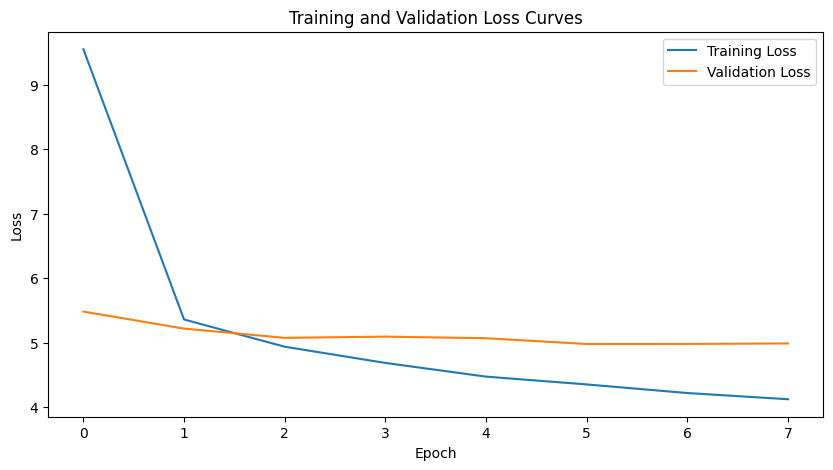

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
#ax = plt.gca()
#ax.set_ylim([0, 300])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate on test set

In [31]:
test_loss, test_mae = model.evaluate(test_dataset)

52/52 [==============================] - 5s 100ms/step - loss: 4.7903 - mae: 5.2648


Visualize the most significant errors

In [ ]:
predictions = model.predict(test_dataset)
true_labels = []
test_images = []

for img_batch, lbl_batch in test_dataset.unbatch():  # unbatch the dataset
    true_labels.append(lbl_batch.numpy())
    test_images.append(img_batch.numpy())

true_labels = np.array(true_labels)
predictions = predictions.flatten()  # Flatten predictions to match label shape
test_images = np.stack(test_images)

errors = np.abs(predictions - true_labels)

biggest_errors_idx = np.argsort(errors)[-10:]  # for example, get top 10 errors

import matplotlib.pyplot as plt

for idx in biggest_errors_idx:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[idx].astype('uint8'))
    plt.title(f'Predicted Age: {int(predictions[idx])}, True Age: {true_labels[idx]}')
    plt.axis('off')
    plt.show()

Plot the age distribution of true vs. predicted values from the test set

207/207 [==============================] - 371s 2s/step


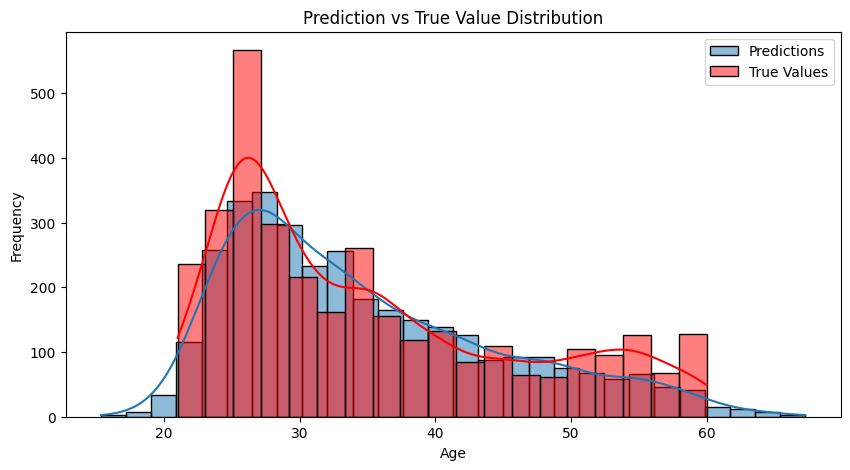

In [14]:
#y_pred = model.predict(test_dataset)
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

plt.figure(figsize=(10, 5))
sns.histplot(y_pred, kde=True, color='blue', label='Predictions')
sns.histplot(y_true, kde=True, color='red', label='True Values')
plt.title('Prediction vs True Value Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
y_val = np.concatenate([y for x, y in val_dataset], axis=0)
y_val[30:55]

array([34, 12, 26, 43, 57, 26, 12, 30, 28, 60, 78, 43, 26,  4, 32, 52, 20,
       25, 22,  2, 29, 39, 27, 26, 30], dtype=int32)

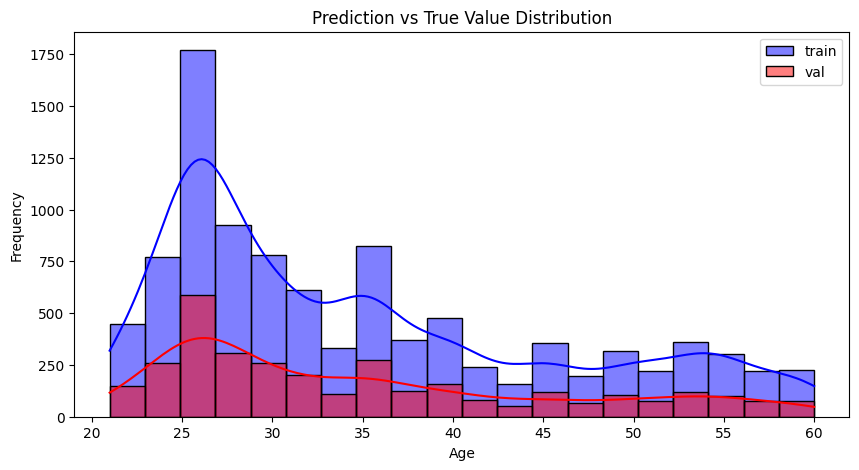

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True, color='blue', label='train', bins = 20)
sns.histplot(y_val, kde=True, color='red', label='val', bins = 20)
plt.title('Prediction vs True Value Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()